In [37]:
# ===============================
# STEP 1: IMPORT LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import re
import nltk
import warnings
warnings.filterwarnings('ignore')

# NLP & Sentiment
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Database
import sqlite3
import os
from datetime import datetime, timedelta

# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to C:\Users\Teesa
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Teesa
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Teesa
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
# ===============================
# STEP 2: SIMULATE TWITTER DATA (instead of snscrape)
# ===============================
data = {
    "date": pd.date_range(end=datetime.today(), periods=100).tolist(),
    "username": [f"user{i}" for i in range(100)],
    "tweet": [
        "IRCTC booking system is so fast and reliable!",
        "I hate how IRCTC servers crash during Tatkal.",
        "IRCTC food service was decent.",
        "Train got delayed, but customer support helped.",
        "IRCTC app interface needs improvement.",
        "Love the new seat selection option!",
        "Worst experience booking train tickets online.",
        "IRCTC deserves appreciation for punctuality.",
        "Got refund quickly! IRCTC doing great.",
        "Why does IRCTC still have captcha on every page?"
    ] * 10
}

tweets_df = pd.DataFrame(data)
print(f"✅ Simulated {len(tweets_df)} tweets for IRCTC analysis.")
tweets_df.head()


✅ Simulated 100 tweets for IRCTC analysis.


,date,username,tweet
0,2025-08-05 23:50:09.850436,user0,IRCTC booking system is so fast and reliable!
1,2025-08-06 23:50:09.850436,user1,I hate how IRCTC servers crash during Tatkal.
2,2025-08-07 23:50:09.850436,user2,IRCTC food service was decent.
3,2025-08-08 23:50:09.850436,user3,"Train got delayed, but customer support helped."
4,2025-08-09 23:50:09.850436,user4,IRCTC app interface needs improvement.


In [39]:
# ===============================
# STEP 2.1: SAVE SIMULATED TWITTER DATA TO CSV
# ===============================

# Define your save path (same as other datasets)
csv_simulated_tweets = r"C:\Users\Teesa Sharma\Desktop\Text,web analytics\data\simulated_irctc_tweets.csv"

# Save to CSV
tweets_df.to_csv(csv_simulated_tweets, index=False, encoding='utf-8')

print(f"✅ Simulated IRCTC Twitter data saved successfully at:\n{csv_simulated_tweets}")


✅ Simulated IRCTC Twitter data saved successfully at:
C:\Users\Teesa Sharma\Desktop\Text,web analytics\data\simulated_irctc_tweets.csv


In [40]:
# ===============================
# STEP 3: TEXT CLEANING
# ===============================
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

tweets_df['clean_tweet'] = tweets_df['tweet'].apply(clean_text)
tweets_df.head()


,date,username,tweet,clean_tweet
0,2025-08-05 23:50:09.850436,user0,IRCTC booking system is so fast and reliable!,irctc booking system fast reliable
1,2025-08-06 23:50:09.850436,user1,I hate how IRCTC servers crash during Tatkal.,hate irctc server crash tatkal
2,2025-08-07 23:50:09.850436,user2,IRCTC food service was decent.,irctc food service decent
3,2025-08-08 23:50:09.850436,user3,"Train got delayed, but customer support helped.",train got delayed customer support helped
4,2025-08-09 23:50:09.850436,user4,IRCTC app interface needs improvement.,irctc app interface need improvement


In [41]:
# ===============================
# STEP 4: SENTIMENT ANALYSIS (VADER + TEXTBLOB)
# ===============================
analyzer = SentimentIntensityAnalyzer()

tweets_df['vader_score'] = tweets_df['clean_tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
tweets_df['textblob_polarity'] = tweets_df['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

def get_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return None

tweets_df['sentiment'] = tweets_df['vader_score'].apply(get_sentiment)
tweets_df = tweets_df.dropna(subset=['sentiment'])

print("✅ Sentiment analysis complete.")
tweets_df[['tweet', 'sentiment']].head()


✅ Sentiment analysis complete.


,tweet,sentiment
1,I hate how IRCTC servers crash during Tatkal.,Negative
3,"Train got delayed, but customer support helped.",Positive
4,IRCTC app interface needs improvement.,Positive
5,Love the new seat selection option!,Positive
6,Worst experience booking train tickets online.,Negative


In [42]:
# ===============================
# STEP 5: SAVE TO CSV + DATABASE
# ===============================
csv_path = r"C:\Users\Teesa Sharma\Desktop\Text,web analytics\data\irctc_twitter_sentiment.csv"
db_path = r"C:\Users\Teesa Sharma\Desktop\Text,web analytics\data\irctc_reviews.db"

tweets_df.to_csv(csv_path, index=False)
conn = sqlite3.connect(db_path)
tweets_df.to_sql('irctc_tweets', conn, if_exists='replace', index=False)
conn.close()

print(f"✅ Data saved:\nCSV: {csv_path}\nDB: {db_path}")


✅ Data saved:
CSV: C:\Users\Teesa Sharma\Desktop\Text,web analytics\data\irctc_twitter_sentiment.csv
DB: C:\Users\Teesa Sharma\Desktop\Text,web analytics\data\irctc_reviews.db


In [43]:
# ===============================
# STEP 6: VISUALS DIRECTORY
# ===============================
save_dir = r"C:\Users\Teesa Sharma\Desktop\Text,web analytics\visuals"
os.makedirs(save_dir, exist_ok=True)
print(f"✅ Visuals will be saved to: {save_dir}")


✅ Visuals will be saved to: C:\Users\Teesa Sharma\Desktop\Text,web analytics\visuals


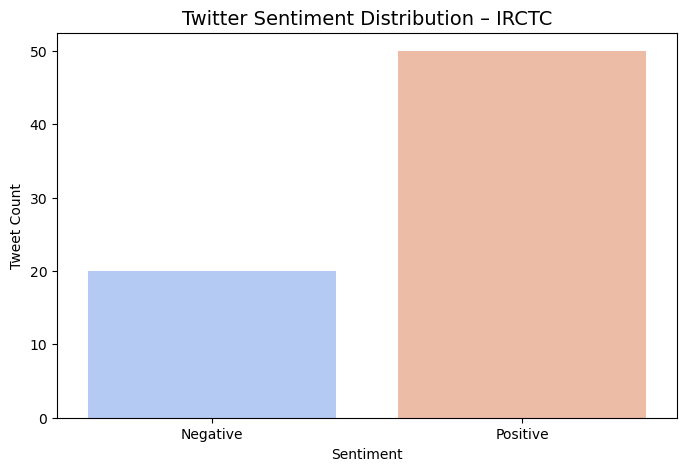

✅ Sentiment Distribution saved at: C:\Users\Teesa Sharma\Desktop\Text,web analytics\visuals\twitter_sentiment_distribution.png


In [44]:
# ===============================
# STEP 7: SENTIMENT DISTRIBUTION
# ===============================
plt.figure(figsize=(8,5))
sns.countplot(x='sentiment', data=tweets_df, palette='coolwarm')
plt.title("Twitter Sentiment Distribution – IRCTC", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")

sent_bar_path = os.path.join(save_dir, "twitter_sentiment_distribution.png")
plt.savefig(sent_bar_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Sentiment Distribution saved at: {sent_bar_path}")


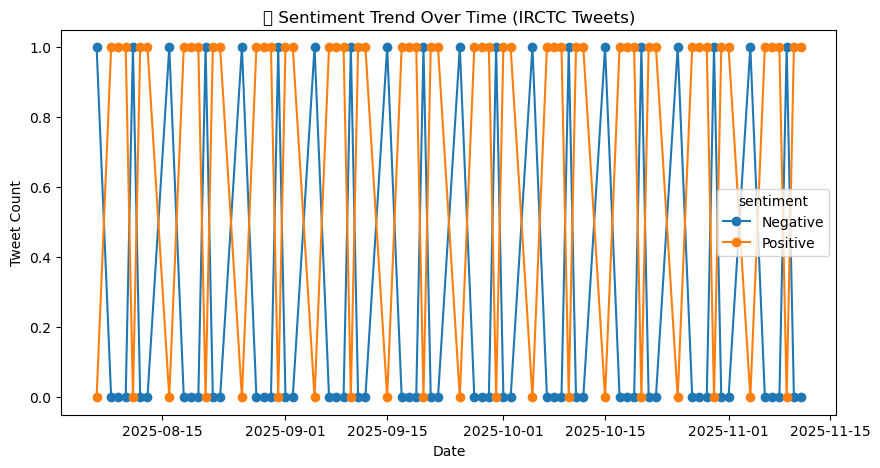

✅ Sentiment Trend Chart saved at: C:\Users\Teesa Sharma\Desktop\Text,web analytics\visuals\twitter_sentiment_trend.png


In [45]:
# ===============================
# STEP 8: SENTIMENT TREND (LINE)
# ===============================
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
tweets_df['date_only'] = tweets_df['date'].dt.date

trend_df = tweets_df.groupby(['date_only', 'sentiment']).size().unstack().fillna(0)

trend_df.plot(kind='line', marker='o', figsize=(10,5))
plt.title("📈 Sentiment Trend Over Time (IRCTC Tweets)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")

trend_path = os.path.join(save_dir, "twitter_sentiment_trend.png")
plt.savefig(trend_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Sentiment Trend Chart saved at: {trend_path}")


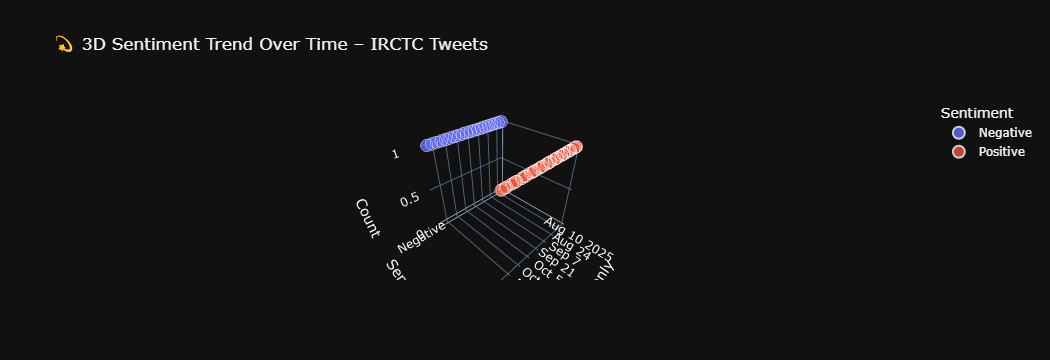

✅ 3D Sentiment Trend Visualization saved at: C:\Users\Teesa Sharma\Desktop\Text,web analytics\visuals\3D_twitter_sentiment_trend.html


In [46]:
# ===============================
# STEP 9: 3D SENTIMENT TREND
# ===============================
trend_df_reset = trend_df.reset_index().melt(id_vars='date_only', var_name='Sentiment', value_name='Count')

fig = px.scatter_3d(
    trend_df_reset,
    x='date_only', y='Sentiment', z='Count',
    color='Sentiment',
    size='Count',
    title='💫 3D Sentiment Trend Over Time – IRCTC Tweets',
    template='plotly_dark'
)
fig.update_traces(marker=dict(opacity=0.8))
fig.show()

trend3d_path = os.path.join(save_dir, "3D_twitter_sentiment_trend.html")
fig.write_html(trend3d_path)
print(f"✅ 3D Sentiment Trend Visualization saved at: {trend3d_path}")


In [47]:
# ===============================
# STEP 10: VERIFY DATABASE
# ===============================
conn = sqlite3.connect(db_path)
pd.read_sql("SELECT sentiment, COUNT(*) as count FROM irctc_tweets GROUP BY sentiment", conn)
conn.close()
